In [0]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, f_regression

import itertools

import warnings
import json

warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'./noFinacialFeatures.csv'
f_data_path = r'./FinacialFeatures.csv'

# flevel = json.load(open(r'./feature_level.json'))

In [0]:
nf_df = pd.read_csv(nf_data_path)
f_df = pd.read_csv(f_data_path)

In [0]:
df = pd.DataFrame()
df = nf_df.copy()
f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')

In [0]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)

In [79]:
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)

(2364, 307) (592, 307) (2364,) (592,)


In [0]:
def print_(gs):
    print(gs.cv_results_)
    print(gs.best_params_)
    print(gs.best_score_)
    print('rmse:', np.sqrt(np.abs(gs.best_score_)))

# Cross validation

In [0]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

## Sample

In [0]:
# params = {'num_leaves': 50,
#           'min_data_in_leaf': 30,
#           'objective': 'regression',
#           'max_depth': 6,
#           'learning_rate': 0.1,
#           "min_child_samples": 100,
#           "boosting": "gbdt",
#           "feature_fraction": 0.8,
#           "bagging_freq": 1,
#           "bagging_fraction": 0.7,
#           "bagging_seed": 11,
#           "metric": 'rmse',
#           "lambda_l1": 0.1,
#           "verbosity": -1,
#           "device":'cpu',
#           "n_jobs":4,
#           "n_estimators":941}


params = {'num_leaves': 80,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "n_jobs":8,
         "n_estimators":941}


In [0]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=150)
    
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits
    
    
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.97346	valid_1's rmse: 3.00919
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.40454	valid_1's rmse: 2.98727
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.96027	valid_1's rmse: 3.35494
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.36978	valid_1's rmse: 3.32063
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.96716	valid_1's rmse: 3.08877
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.39434	valid_1's rmse: 3.05962
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.95053	valid_1's rmse: 3.30398
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.37984	valid_1's rmse: 3.22539
----
fold n°4
Training until validation scores don't improve

3.0064682521775197

## Traing with feature level

In [0]:
def train_lgbm(xtrain, ytrain, xtest, ytest, params):
    feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
    mvalid = np.zeros(len(xtrain))
    mfull = np.zeros(len(xtest))
    models = []


    for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
        print('----')
        print("fold n°{}".format(fold_))

        x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
        x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

        trn_data = lgb.Dataset(x0, label=y0)
        val_data = lgb.Dataset(x1, label=y1)

        num_round = 10000
        clf = lgb.train(params,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=150)

        mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

        feature_importance_df[:, fold_] = clf.feature_importance()

        mfull += clf.predict(xtest,
                             num_iteration=clf.best_iteration) / folds.n_splits
        
        models.append(clf)


    test_error=np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))
    print()
    print('rmse:', test_error)
    return models, test_error, feature_importance_df

### All features

In [0]:
params_all={
    # objective and metric
    "objective": "regression",
    "metric": 'rmse',
    "boosting": "gbdt",

    # for the Leaf-wise (Best-first) Tree
    "num_leaves": 110, 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
    "min_data_in_leaf": 20, # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": 7, # limit the tree depth explicitly.

    # For Faster Speed
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
#     "max_bin": 5, # more small more faster
    "bagging_seed": 11,

    # For Better Accuracy
    "max_bin": 30, # lager but slower
    "learning_rate": 0.005,

    # deal with over fitting
      # Use small max_bin
      # Use small num_leaves
      # Use min_data_in_leaf and min_sum_hessian_in_leaf
      # Use bagging by set bagging_fraction and bagging_freq
      # Use feature sub-sampling by set feature_fraction
      # Use bigger training data
      # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
      # Try max_depth to avoid growing deep tree
    "feature_fraction": 0.8,
    "lambda_l1": 0.9,

    "min_child_samples": 100,

    # other
    "n_estimators": 1500, # num_itertations的别名，默认是100.也就是循环次数，或者叫树的数目
    "verbosity": -1,
    "n_jobs":-1,
}

In [0]:
models, test_error, feature_importance_df = train_lgbm(xtrain, ytrain, xtest, ytest, params_all)

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.27183	valid_1's rmse: 2.97002
[1000]	training's rmse: 1.68318	valid_1's rmse: 2.92879
Early stopping, best iteration is:
[931]	training's rmse: 1.74646	valid_1's rmse: 2.92599
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.25505	valid_1's rmse: 3.31184
[1000]	training's rmse: 1.65527	valid_1's rmse: 3.26789
Early stopping, best iteration is:
[982]	training's rmse: 1.67173	valid_1's rmse: 3.26701
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.26921	valid_1's rmse: 3.07128
[1000]	training's rmse: 1.67511	valid_1's rmse: 3.03087
Early stopping, best iteration is:
[950]	training's rmse: 1.72059	valid_1's rmse: 3.02857
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.26115	valid_1's rmse: 3.28847
[1000]	training's rmse: 1.66384	va

## Params search

In [0]:
params_all = {
    # objective and metric
    "objective": "regression",
    "metric": 'rmse',
    "boosting": "gbdt",

    # for the Leaf-wise (Best-first) Tree
    "num_leaves": 100, 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
    "min_data_in_leaf": 30, # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": 7, # limit the tree depth explicitly.

    # For Faster Speed
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
#     "max_bin": 5, # more small more faster
    "bagging_seed": 11,

    # For Better Accuracy
    "max_bin": 20, # lager but slower
    "learning_rate": 0.005,

    # deal with over fitting
      # Use small max_bin
      # Use small num_leaves
      # Use min_data_in_leaf and min_sum_hessian_in_leaf
      # Use bagging by set bagging_fraction and bagging_freq
      # Use feature sub-sampling by set feature_fraction
      # Use bigger training data
      # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
      # Try max_depth to avoid growing deep tree
    "feature_fraction": 0.8,
    "lambda_l1": 0.9,

    "min_child_samples": 100,

    # other
    "n_estimators": 1500,
    "verbosity": -1,
    "n_jobs":-1,
}

In [0]:
params_range_dict = {# for the Leaf-wise (Best-first) Tree
    "num_leaves": np.arange(10,160,10, dtype=int), 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
#     "min_data_in_leaf": np.arange(10,55,5), # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": np.arange(4,13,1, dtype=int), # limit the tree depth explicitly.

#     # For Faster Speed
#     "bagging_fraction": np.arange(0.5, 1,0.1),

#     # For Better Accuracy
    "max_bin": np.arange(10,60,5, dtype=int), # lager but slower

#     "feature_fraction": np.arange(0.3, 1, 0.1),
#     "lambda_l1": np.arange(0.01, 1, 0.05),

#     "min_child_samples": np.arange(70, 110,10),
}

In [0]:
def search_params(params_range_dict, xtrain, ytrain, xtest, ytest):
    best_rmse = np.inf
    count = 0
    train_dict = {}
    params_name = list(params_range_dict.keys())
    params_values = []
    for name in params_name:
        params_values.append(params_range_dict[name])

    c_params = list(itertools.product(*params_values))
    idx = [i for i in range(0, len(c_params))]

    params_df = pd.DataFrame(c_params, index=idx, columns=params_name)
    print('Iteration number:', len(params_df))
    for row in range(0, len(params_df)):
        print('*********************************Iteration: %s****************************************************' % str(count))
        starttime = time.time()
        each_params = params_df.iloc[row].to_dict()
        print('Current params:', each_params)
        params_all.update(each_params)
        models, test_error, feature_importance_df = train_lgbm(
            xtrain, ytrain, xtest, ytest, params_all)

        print("Used %s seconds" % (time.time() - starttime))

        count += 1

        if test_error < best_rmse:
            best_rmse = test_error
            train_dict = {'models': models, 'rmse': test_error,
                          'feature_importance': feature_importance_df, 'params': each_params}
        print('Current best:', best_rmse, 'Params:', train_dict['params'])
        print()

    return train_dict

# Feature selection

In [85]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

stddf=x.describe().loc[['std']]
stddf.loc['variance'] = stddf.loc['std']**2

stddf.drop(['企业编号'],axis=1,inplace=True)

variance=stddf.T
variance['feature']=variance.index
variance.drop(['std'],axis=1,inplace=True)
features=ximp.merge(variance, how='left',on='feature')

features=features.sort_values(by=['importance'], ascending=False)
features['rank']=(np.arange(1,len(features)+1))
features.to_csv(r'feature_importance.csv',index=False)
features

,feature,importance,variance,rank
0,软著数量,1194.0,3.332944e+03,1
16,发明授权,727.4,6.029148e+05,2
18,实用新型,642.9,3.128945e+05,3
17,外观设计,601.3,3.486098e+04,4
15,发明公布,582.7,2.674838e+06,5
74,商标数量,501.6,2.265722e+04,6
7,资质证书数量,449.5,4.159539e+04,7
62,成立年数,305.7,2.253465e+01,8
42,行业大类_C,300.7,2.500841e-01,9
1,作品著作数量,295.3,3.005290e+04,10


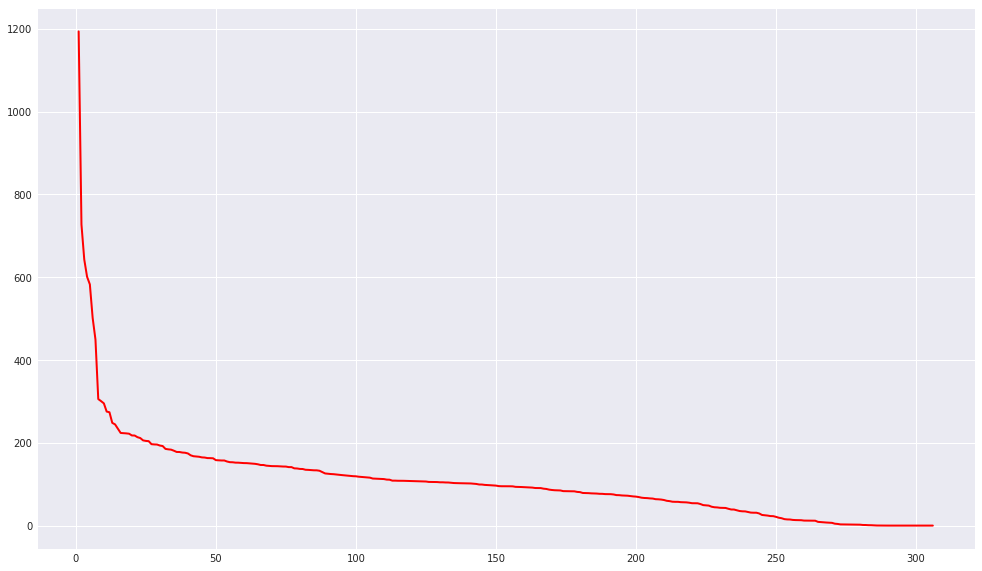

In [59]:
plt.figure(figsize=(15,10))
plt.plot(features['rank'],features['importance'],color="red",linewidth=2)

In [86]:
importance_threshold=int((features.loc[(features['rank']<=features['importance'])]).iloc[-1].to_dict()['rank'])
importance_threshold_sqrt=int((features.loc[(np.sqrt(features['rank'])<=features['importance'])]).iloc[-1].to_dict()['rank'])
importance_threshold, importance_threshold_sqrt

(111, 252)

In [0]:
def feature_importance_filter(im_threshold):
  selected_features=list(features.loc[(features['rank']<=im_threshold)]['feature'])
  selected_features.append('企业编号')
  return x[list(selected_features)], selected_features

In [0]:
x_im_filter, selected_features=feature_importance_filter(importance_threshold)
x_im_filter_sqrt, selected_features_sqrt=feature_importance_filter(importance_threshold_sqrt)

In [89]:
# imp_feature = (features.loc[(features['feature'].isin(pd.Series(selected_features)))]).sort_values(by=['variance'], ascending=False)
# imp_feature
x_im_filter.shape

(2956, 112)

In [0]:
def split_train_set(x_filter, y):
  xtrain_filter, xtest_filter, ytrain, ytest = train_test_split(
      x_filter, y, test_size=0.2, random_state=0)
  ytrain_id = ytrain['企业编号']
  ytrain = ytrain['企业总评分']
  ytest_id = ytest['企业编号']
  ytest = ytest['企业总评分']
  
  id_train = xtrain_filter['企业编号']
  id_test = xtest_filter['企业编号']
  xtrain_filter.drop(['企业编号'], axis=1, inplace=True)
  xtest_filter.drop(['企业编号'], axis=1, inplace=True)
  print(xtrain_filter.shape, xtest_filter.shape, ytrain.shape, ytest.shape)
  return xtrain_filter, xtest_filter, ytrain_id, ytest_id, id_train, id_test

In [93]:
xtrain_filter, xtest_filter, ytrain_id, ytest_id, id_train, id_test=split_train_set(x_im_filter, y)
xtrain_filter_sqrt, xtest_filter_sqrt, ytrain_id_sqrt, ytest_id_sqrt, id_train_sqrt, id_test_sqrt=split_train_set(x_im_filter_sqrt, y)

(2364, 111) (592, 111) (2364,) (592,)
(2364, 252) (592, 252) (2364,) (592,)


In [0]:
train_dict_filter = search_params(params_range_dict, xtrain_filter, ytrain, xtest_filter, ytest)

Iteration number: 1350
*********************************Iteration: 0****************************************************
Current params: {'num_leaves': 10, 'max_depth': 4, 'max_bin': 10}
----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.04728	valid_1's rmse: 3.01377
[1000]	training's rmse: 2.71835	valid_1's rmse: 2.92729
Early stopping, best iteration is:
[1298]	training's rmse: 2.58933	valid_1's rmse: 2.91708
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.0132	valid_1's rmse: 3.40852
[1000]	training's rmse: 2.68374	valid_1's rmse: 3.30889
[1500]	training's rmse: 2.47977	valid_1's rmse: 3.2998
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 2.47977	valid_1's rmse: 3.2998
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.0353	valid_1's rmse: 3.16948
[1000]	training's rmse: 2.70695	valid_1's rmse: 3.08784
Ea

In [0]:
train_dict_filter_sqrt = search_params(params_range_dict, xtrain_filter_sqrt, ytrain, xtest_filter_sqrt, ytest)